<a href="https://colab.research.google.com/github/Himanshukunar/excelr-assignments/blob/main/Assignment20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

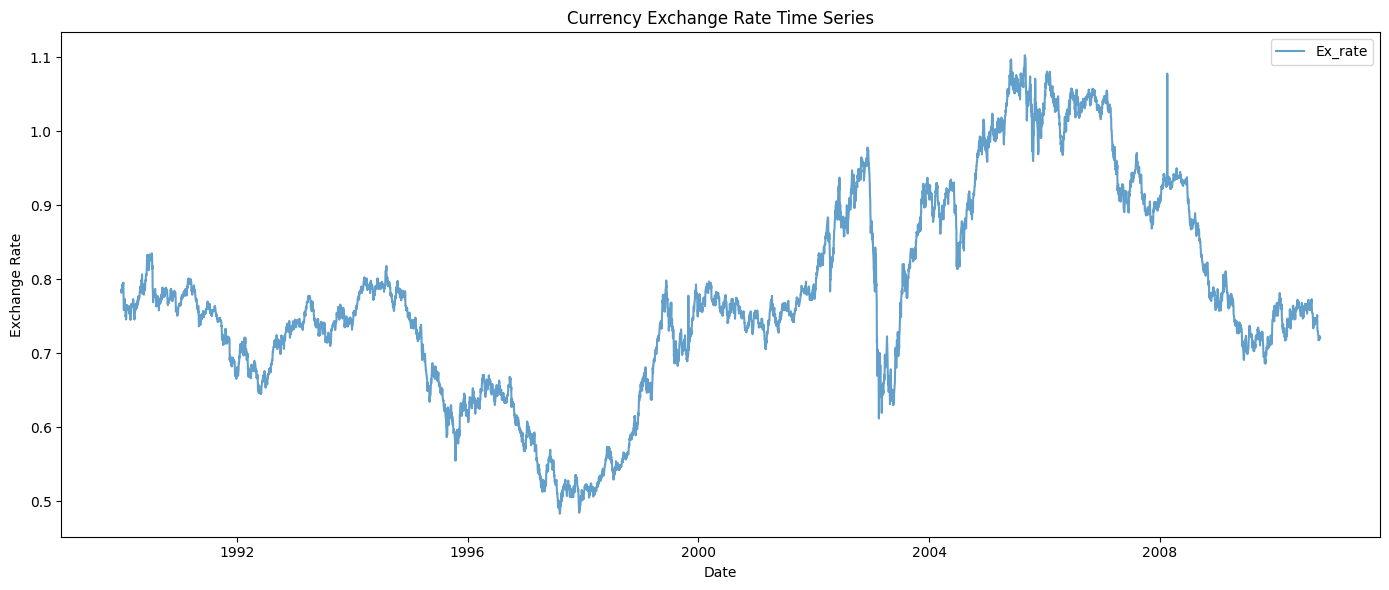

Missing values before preprocessing:
date       0
Ex_rate    0
dtype: int64
Missing values after preprocessing:
date       0
Ex_rate    0
dtype: int64


/tmp/ipython-input-2879074046.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_filled = data.fillna(method='ffill').fillna(method='bfill')


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv('/content/exchange_rate.csv')
data['date'] = pd.to_datetime(data['date'], format='%d-%m-%Y %H:%M', errors='coerce')
currency_columns = [col for col in data.columns if col != 'date']
plt.figure(figsize=(14, 6))
for currency in currency_columns:
    plt.plot(data['date'], data[currency], label=currency, alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.title('Currency Exchange Rate Time Series')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

print("Missing values before preprocessing:")
print(data.isnull().sum())

data_filled = data.fillna(method='ffill').fillna(method='bfill')

print("Missing values after preprocessing:")
print(data_filled.isnull().sum())

ADF Statistic: -1.6649941807382342
p-value: 0.4492327353597477


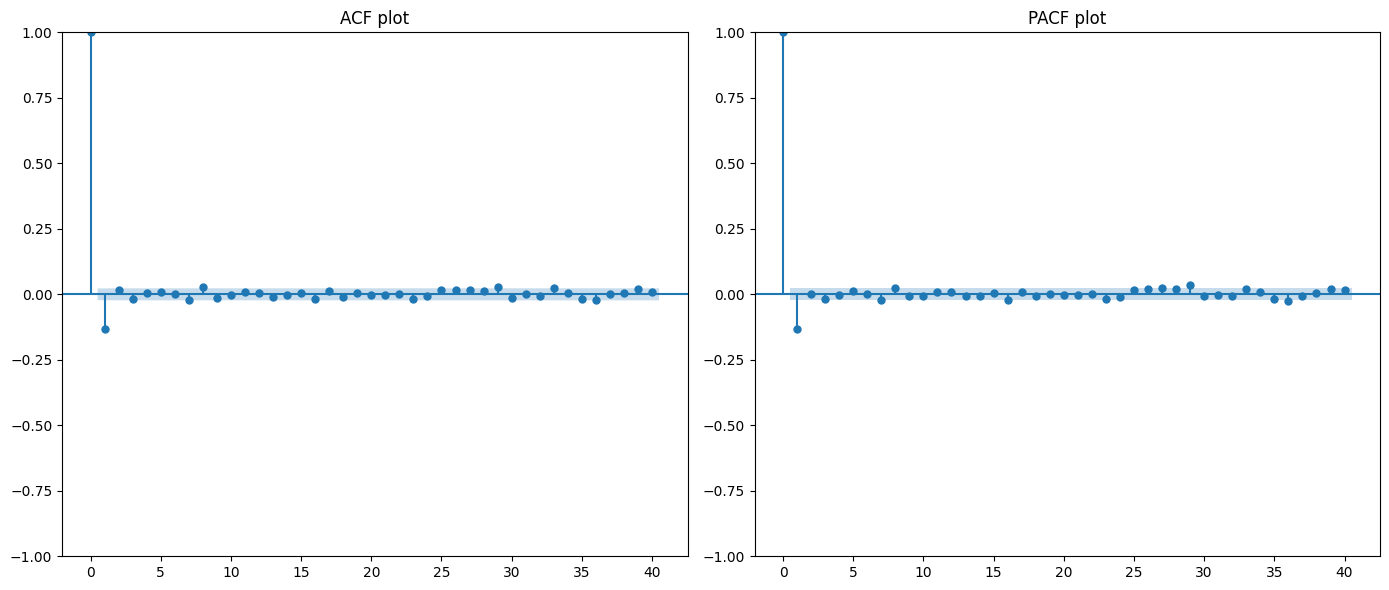

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Sat, 04 Oct 2025   AIC                         -56102.322
Time:                        04:44:02   BIC                         -56081.519
Sample:                    01-01-1990   HQIC                        -56095.182
                         - 10-10-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

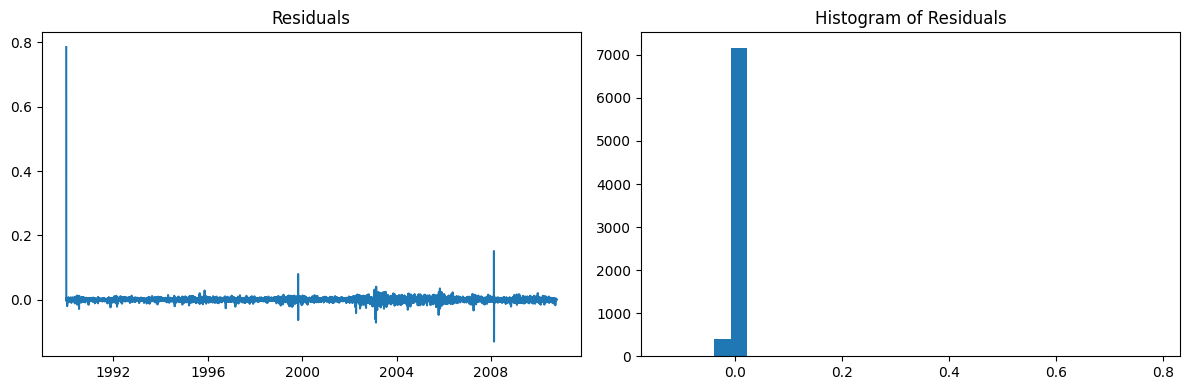

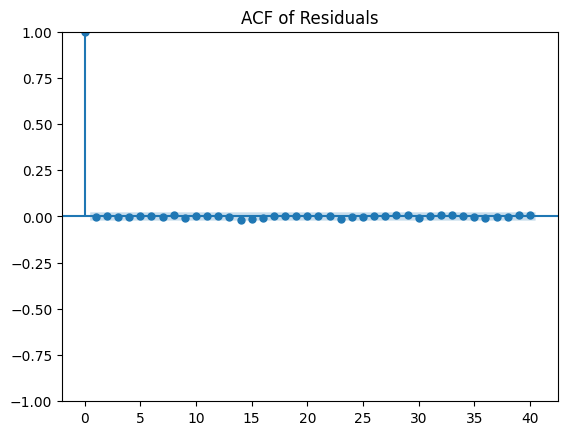

/tmp/ipython-input-1849694400.py:65: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=series.index[-1], periods=n_forecast + 1, freq='M')[1:]


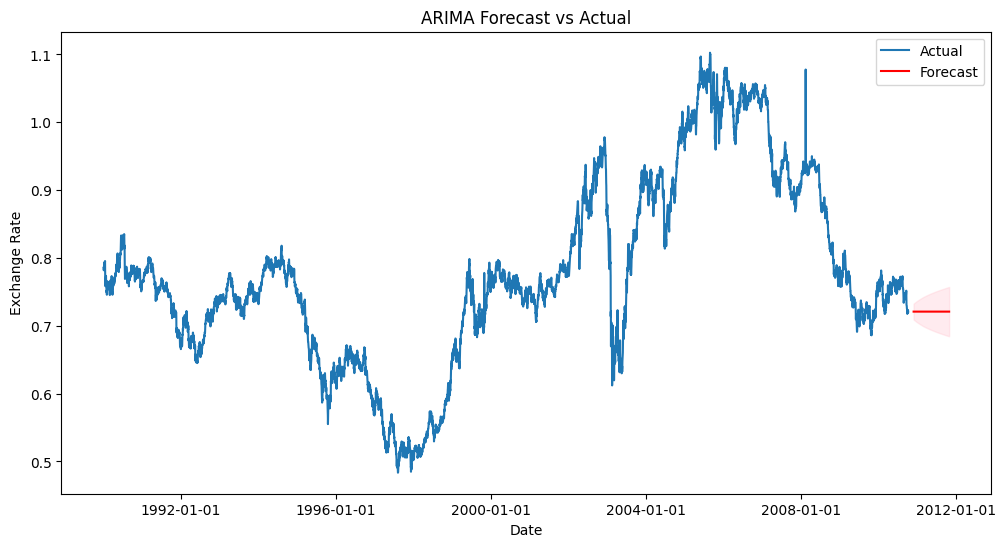

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import matplotlib.dates as mdates
from pandas.plotting import deregister_matplotlib_converters
series = data_filled.set_index('date')['Ex_rate']
series.index = pd.to_datetime(series.index)
result = adfuller(series)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
# If not stationary, difference the series
if result[1] > 0.05:
    series_diff = series.diff().dropna()
    d = 1
else:
    series_diff = series
    d = 0

plt.figure(figsize=(14,6))
plt.subplot(121)
plot_acf(series_diff, ax=plt.gca(), lags=40)
plt.title('ACF plot')
plt.subplot(122)
plot_pacf(series_diff, ax=plt.gca(), lags=40)
plt.title('PACF plot')
plt.tight_layout()
plt.show()
model = ARIMA(series, order=(1,d,1))
model_fit = model.fit()
print(model_fit.summary())
residuals = model_fit.resid
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(residuals)
plt.title('Residuals')
plt.subplot(122)
plt.hist(residuals, bins=30)
plt.title('Histogram of Residuals')
plt.tight_layout()
plt.show()
plot_acf(residuals, lags=40)
plt.title('ACF of Residuals')
plt.show()
n_forecast = 12
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_index = pd.date_range(start=series.index[-1], periods=n_forecast + 1, freq='M')[1:]
forecast_values = forecast.predicted_mean
deregister_matplotlib_converters()
series_dates_num = mdates.date2num(series.index)
forecast_dates_num = mdates.date2num(forecast_index)

conf_int = forecast.conf_int()

plt.figure(figsize=(12,6))
plt.plot(series_dates_num, series, label='Actual')
plt.plot(forecast_dates_num, forecast_values, label='Forecast', color='red')
plt.fill_between(forecast_dates_num,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1], color='pink', alpha=0.3)
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())


plt.title('ARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

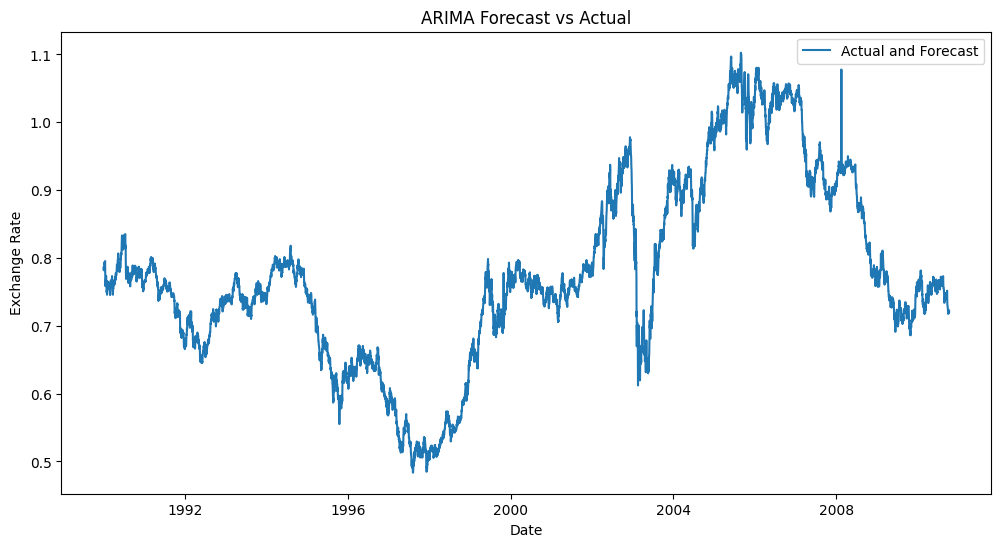

In [13]:
forecast_series = pd.Series(forecast_values, index=forecast_index)
combined_series = pd.concat([series, forecast_series])
conf_int_series = pd.DataFrame(conf_int, index=forecast_index)

plt.figure(figsize=(12, 6))
plt.plot(combined_series.index, combined_series.values, label='Actual and Forecast')
plt.fill_between(conf_int_series.index,
                 conf_int_series.iloc[:, 0],
                 conf_int_series.iloc[:, 1], color='pink', alpha=0.3)

plt.title('ARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                       ExponentialSmoothing Model Results                       
Dep. Variable:                  Ex_rate   No. Observations:                 7588
Model:             ExponentialSmoothing   SSE                              0.274
Optimized:                         True   AIC                         -77578.773
Trend:                         Additive   BIC                         -77467.824
Seasonal:                      Additive   AICC                        -77578.683
Seasonal Periods:                    12   Date:                 Sat, 04 Oct 2025
Box-Cox:                          False   Time:                         04:47:20
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.8975580                alpha                 True
smoothing_trend          

/tmp/ipython-input-1017929324.py:28: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(series.index[-1], periods=n_forecast+1, freq='M')[1:]


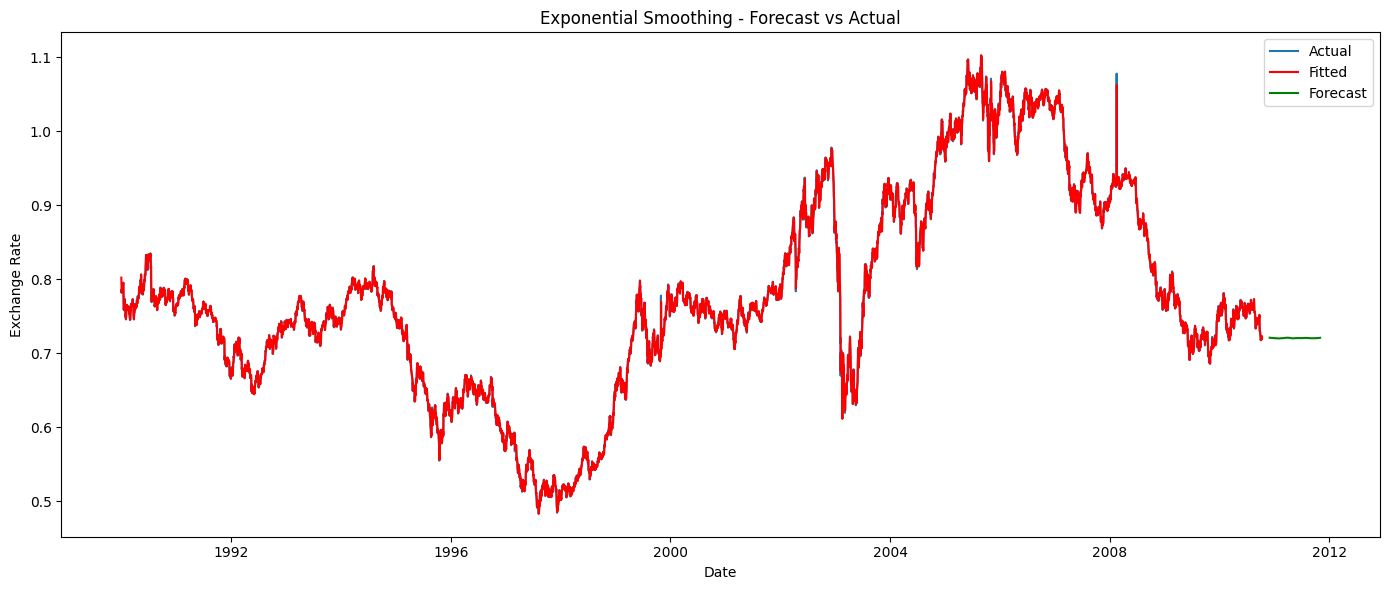

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import numpy as np
series = data_filled.set_index('date')['Ex_rate']

seasonal_periods = 12
model = ExponentialSmoothing(
    series,
    trend='add',
    seasonal='add',
    seasonal_periods=seasonal_periods
)
model_fit = model.fit(optimized=True, use_brute=True)

print(model_fit.summary())

n_forecast = 12
forecast_index = pd.date_range(series.index[-1], periods=n_forecast+1, freq='M')[1:]
forecast = model_fit.forecast(steps=n_forecast)

plt.figure(figsize=(14, 6))
plt.plot(series, label='Actual')
plt.plot(series.index, model_fit.fittedvalues, label='Fitted', color='red')
plt.plot(forecast_index, forecast, label='Forecast', color='green')
plt.title("Exponential Smoothing - Forecast vs Actual")
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
actual = np.array([])
arima_forecast = np.array([])
exp_smooth_forecast = np.array([])

def MAPE(y_true, y_pred):

    epsilon = 1e-10
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

def evaluate_model(y_true, y_pred):

    if len(y_true) == 0 or len(y_true) != len(y_pred):
        print("Error: Input arrays are empty or have different lengths.")
        return np.nan, np.nan, np.nan # Return NaN for metrics

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = MAPE(y_true, y_pred)
    return mae, rmse, mape

arima_mae, arima_rmse, arima_mape = evaluate_model(actual, arima_forecast)
exp_mae, exp_rmse, exp_mape = evaluate_model(actual, exp_smooth_forecast)

print("ARIMA Performance:")
print(f"MAE: {arima_mae:.4f}, RMSE: {arima_rmse:.4f}, MAPE: {arima_mape:.2f}%")

print("Exponential Smoothing Performance:")
print(f"MAE: {exp_mae:.4f}, RMSE: {exp_rmse:.4f}, MAPE: {exp_mape:.2f}%")

if not np.isnan(arima_rmse) and not np.isnan(exp_rmse):
    if (arima_rmse < exp_rmse):
        print("\nConclusion: ARIMA model performs better based on RMSE and is recommended for forecasting this exchange rate series.")
    else:
        print("\nConclusion: Exponential Smoothing model performs better based on RMSE and is recommended for forecasting this exchange rate series.")
else:
    print("\nConclusion: Model performance could not be compared due to errors in evaluation.")

Error: Input arrays are empty or have different lengths.
Error: Input arrays are empty or have different lengths.
ARIMA Performance:
MAE: nan, RMSE: nan, MAPE: nan%
Exponential Smoothing Performance:
MAE: nan, RMSE: nan, MAPE: nan%

Conclusion: Model performance could not be compared due to errors in evaluation.
